# A Recommendation Engine for The Recipes by Using Collaborative Filtering in Python

## import libraries and data analysis

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split as sk_train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics.pairwise import cosine_similarity
from surprise import Dataset, Reader, SVD
from surprise.model_selection import train_test_split as sp_train_test_split
from surprise.accuracy import rmse

In [2]:
# read the dataset
reviews_df = pd.read_csv('./Data_Source/interactions_train.csv')
recipes_df = pd.read_csv('./Data_Source/RAW_recipes.csv')
#recipes_img = pd.read_parquet('./Data_Source/recipes.parquet')
display(reviews_df.info())
display(recipes_df.info())
#display(recipes_img.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 698901 entries, 0 to 698900
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   user_id    698901 non-null  int64  
 1   recipe_id  698901 non-null  int64  
 2   date       698901 non-null  object 
 3   rating     698901 non-null  float64
 4   u          698901 non-null  int64  
 5   i          698901 non-null  int64  
dtypes: float64(1), int64(4), object(1)
memory usage: 32.0+ MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 231637 entries, 0 to 231636
Data columns (total 12 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   name            231636 non-null  object
 1   id              231637 non-null  int64 
 2   minutes         231637 non-null  int64 
 3   contributor_id  231637 non-null  int64 
 4   submitted       231637 non-null  object
 5   tags            231637 non-null  object
 6   nutrition       231637 non-null  object
 7   n_steps         231637 non-null  int64 
 8   steps           231637 non-null  object
 9   description     226658 non-null  object
 10  ingredients     231637 non-null  object
 11  n_ingredients   231637 non-null  int64 
dtypes: int64(5), object(7)
memory usage: 21.2+ MB


None

In [3]:
print("reviews dataset has ", reviews_df['user_id'].nunique(), " unique users and ", reviews_df['recipe_id'].nunique(), " unique recipes.")

reviews dataset has  25076  unique users and  160901  unique recipes.


In [4]:
reviews_df.head(3)

,user_id,recipe_id,date,rating,u,i
0,2046,4684,2000-02-25,5.0,22095,44367
1,2046,517,2000-02-25,5.0,22095,87844
2,1773,7435,2000-03-13,5.0,24732,138181


In [5]:
recipes_df.head(3)

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients
0,arriba baked winter squash mexican style,137739,55,47892,2005-09-16,"['60-minutes-or-less', 'time-to-make', 'course...","[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,"['winter squash', 'mexican seasoning', 'mixed ...",7
1,a bit different breakfast pizza,31490,30,26278,2002-06-17,"['30-minutes-or-less', 'time-to-make', 'course...","[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]",9,"['preheat oven to 425 degrees f', 'press dough...",this recipe calls for the crust to be prebaked...,"['prepared pizza crust', 'sausage patty', 'egg...",6
2,all in the kitchen chili,112140,130,196586,2005-02-25,"['time-to-make', 'course', 'preparation', 'mai...","[269.8, 22.0, 32.0, 48.0, 39.0, 27.0, 5.0]",6,"['brown ground beef in large pot', 'add choppe...",this modified version of 'mom's' chili was a h...,"['ground beef', 'yellow onions', 'diced tomato...",13


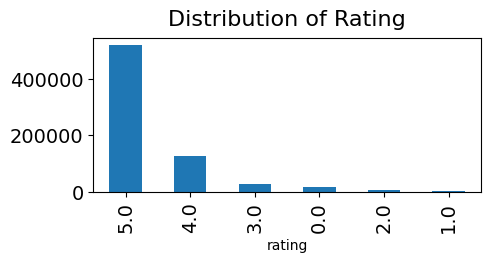

In [6]:
reviews_df['rating'].value_counts().plot(kind = 'bar', fontsize = 14,
                             figsize = (5,2)).set_title('Distribution of Rating',
                                                        fontsize = 16, ha = 'center', va = 'bottom')

plt.show()

## Clean up the data

In [7]:
# Drop columns date, u, i, only keep user_id, recipe_id, rating from the reviews dataframe
reviews_df_filtered = reviews_df.drop(['date', 'u', 'i'], axis = 1)

In [8]:
# Group by user_id and check if all ratings for a user are the same
constant_rating_users = reviews_df_filtered.groupby("user_id")["rating"].nunique() == 1

# Get the list of users who rated every recipe with the same value
users_with_constant_ratings = constant_rating_users[constant_rating_users].index.tolist()

# Remove these users from the dataset
reviews_df_filtered = reviews_df_filtered[~reviews_df_filtered["user_id"].isin(users_with_constant_ratings)]

print(f"Removed {len(users_with_constant_ratings)} users who rated all recipes with the same value.")
print(f"New dataset size: {reviews_df_filtered.shape}")

Removed 7726 users who rated all recipes with the same value.
New dataset size: (661290, 3)


In [9]:
print("reviews dataset has ", reviews_df_filtered['user_id'].nunique(), " unique users and ", reviews_df_filtered['recipe_id'].nunique(), " unique recipes.")

reviews dataset has  17350  unique users and  159975  unique recipes.


### Find Outliers using Z-Score, first normalise the user-bias and recipe-bias by applying baseline_rating method

In [10]:
# find out the baseline rating
# Calculate global mean rating
mu = reviews_df_filtered['rating'].mean()

# Compute user and recipe mean ratings
user_mean = reviews_df_filtered.groupby('user_id')['rating'].mean()
recipe_mean = reviews_df_filtered.groupby('recipe_id')['rating'].mean()

# Merge the mean values back into the dataframe
reviews_df_filtered = reviews_df_filtered.merge(user_mean.rename('user_mean'), on='user_id', how='left')
reviews_df_filtered = reviews_df_filtered.merge(recipe_mean.rename('recipe_mean'), on='recipe_id', how='left')

# Compute biases
reviews_df_filtered['user_bias'] = reviews_df_filtered['user_mean'] - mu
reviews_df_filtered['recipe_bias'] = reviews_df_filtered['recipe_mean'] - mu

# Compute baseline rating
reviews_df_filtered['baseline_rating'] = mu + reviews_df_filtered['user_bias'] + reviews_df_filtered['recipe_bias']

# Compute adjusted rating
# calculate the baseline adjusted rating as (rating - baseline rating),
# this will help minimize the difference between hard raters and easy raters
# also it minimizes the difference between the easily rated recipes and hardly rated recipes
reviews_df_filtered['adjusted_rating'] = reviews_df_filtered['rating'] - reviews_df_filtered['baseline_rating']

# for centered cosine similarity calculation, calculate the mean-centered-rating
reviews_df_filtered.insert(2, 'mean_centered_rating', reviews_df_filtered['rating'] - reviews_df_filtered['user_mean']) 

# Drop unnecessary columns
reviews_df_filtered = reviews_df_filtered.drop(columns=['user_mean', 'recipe_mean', 'user_bias', 'recipe_bias'])
reviews_df_filtered.head(3)

,user_id,recipe_id,mean_centered_rating,rating,baseline_rating,adjusted_rating
0,1773,7435,0.500000,5.0,4.362606,0.637394
1,1773,278,-0.500000,4.0,4.362606,-0.362606
2,2312,780,0.424837,5.0,4.687769,0.312231


In [11]:
# Calculate mean and standard deviation of adjusted ratings
mean_adj = reviews_df_filtered['adjusted_rating'].mean()
std_adj = reviews_df_filtered['adjusted_rating'].std()

# Compute Z-score
reviews_df_filtered['z_score'] = (reviews_df_filtered['adjusted_rating'] - mean_adj) / std_adj
reviews_df_filtered.head(3)

,user_id,recipe_id,mean_centered_rating,rating,baseline_rating,adjusted_rating,z_score
0,1773,7435,0.500000,5.0,4.362606,0.637394,0.816483
1,1773,278,-0.500000,4.0,4.362606,-0.362606,-0.464487
2,2312,780,0.424837,5.0,4.687769,0.312231,0.399959


In [12]:
# Define outliers based on Z-score threshold
outliers = reviews_df_filtered[np.abs(reviews_df_filtered['z_score']) > 3]

print(f"Number of outliers detected: {len(outliers)}")
outliers.head(3)  # Show the outlier rows

Number of outliers detected: 15698


,user_id,recipe_id,mean_centered_rating,rating,baseline_rating,adjusted_rating,z_score
16,5523,7695,-3.375000,1.0,3.920939,-2.920939,-3.741637
28,8000,7585,1.944444,4.0,1.334828,2.665172,3.414007
35,8679,1128,2.500000,5.0,2.445939,2.554061,3.271677


In [13]:
# remove outliers
reviews_df_filtered = reviews_df_filtered[np.abs(reviews_df_filtered['z_score']) <= 3]
# drop all columns except the user_id, recipe_id, rating columns
reviews_df_filtered = reviews_df_filtered[['user_id', 'recipe_id', 'rating']]
# clip extreme values
#reviews_clean['adjusted_rating'] = reviews_clean['adjusted_rating'].clip(lower=-3, upper=3)

In [14]:
# Group by user_id and check if all ratings for a user are the same
constant_rating_users = reviews_df_filtered.groupby("user_id")["rating"].nunique() == 1

# Get the list of users who rated every recipe with the same value
users_with_constant_ratings = constant_rating_users[constant_rating_users].index.tolist()

# Remove these users from the dataset
reviews_df_filtered = reviews_df_filtered[~reviews_df_filtered["user_id"].isin(users_with_constant_ratings)]

print(f"Removed {len(users_with_constant_ratings)} users who rated all recipes with the same value.")
print(f"New dataset size: {reviews_df_filtered.shape}")

Removed 1596 users who rated all recipes with the same value.
New dataset size: (633588, 3)


### Filter Out reviews with Active users(who rated atleast 20 recipes) and popular recipes(have atleast 20 rating)

In [15]:
# Step 1: Identify popular recipes (recipes with at least 20 ratings)
recipe_rating_counts = reviews_df_filtered['recipe_id'].value_counts()
popular_recipes = recipe_rating_counts[recipe_rating_counts >= 20].index

# Step 2: Identify active users (users with at least 20 ratings for popular recipes)
popular_recipes_filtered = reviews_df_filtered[reviews_df_filtered['recipe_id'].isin(popular_recipes)]
user_rating_counts = popular_recipes_filtered['user_id'].value_counts()
active_users = user_rating_counts[user_rating_counts >= 20].index

# Step 3: Apply filters iteratively until constraints are satisfied
while True:
    # Filter for active users and popular recipes
    reviews_qualified = reviews_df_filtered[
        reviews_df_filtered['user_id'].isin(active_users) & reviews_df_filtered['recipe_id'].isin(popular_recipes)
    ].reset_index(drop=True)

    # Recalculate active users and popular recipes in the filtered dataset
    user_rating_counts = reviews_qualified['user_id'].value_counts()
    active_users_new = user_rating_counts[user_rating_counts >= 20].index

    recipe_rating_counts_new = reviews_qualified['recipe_id'].value_counts()
    popular_recipes_new = recipe_rating_counts_new[recipe_rating_counts_new >= 20].index

    # Check for users with constant ratings
    constant_users = []
    for user in active_users_new:
        user_ratings = reviews_qualified[reviews_qualified['user_id'] == user]['rating']
        if user_ratings.nunique() == 1:  # User has constant ratings
            constant_users.append(user)

    # Exclude users with constant ratings
    active_users_new = active_users_new.difference(constant_users)

    # Check if the filters have stabilized
    if set(active_users) == set(active_users_new) and set(popular_recipes) == set(popular_recipes_new):
        break

    # Update the filters
    active_users = active_users_new
    popular_recipes = popular_recipes_new

# Final filtered dataset
reviews_qualified = reviews_df_filtered[
    reviews_df_filtered['user_id'].isin(active_users) & reviews_df_filtered['recipe_id'].isin(popular_recipes)
].reset_index(drop=True)

# Check the result
display(reviews_qualified.shape)
reviews_qualified.head(3)

(62689, 3)

,user_id,recipe_id,rating
0,11297,5478,4.0
1,6357,11642,5.0
2,9869,2886,5.0


In [16]:
constant_rating_users = reviews_qualified.groupby("user_id")["rating"].nunique() == 1

# Get the list of users who rated every recipe with the same value
users_with_constant_ratings = constant_rating_users[constant_rating_users].index.tolist()

print(f"{len(users_with_constant_ratings)} users who rated all recipes with the same value.")

0 users who rated all recipes with the same value.


In [17]:
print('users have rated minimum ', reviews_qualified['user_id'].value_counts().min(), ' recipes and ',
     'the minimum number of rating given to recipes is ', reviews_qualified['recipe_id'].value_counts().min())

users have rated minimum  20  recipes and  the minimum number of rating given to recipes is  20


In [18]:
print('the filtered reviews dataset has ', reviews_qualified['user_id'].nunique(), " unique users and ", 
      reviews_qualified['recipe_id'].nunique(), ' unique recipes.')

the filtered reviews dataset has  1387  unique users and  1608  unique recipes.


### Each user has reviewed 45 recipes on avereage and Each recipe has been rated 38 times on average, this show the data is sparse

In [19]:
display(reviews_qualified['user_id'].value_counts().describe())
display(reviews_qualified['recipe_id'].value_counts().describe())

count    1387.000000
mean       45.197549
std        40.492351
min        20.000000
25%        24.000000
50%        33.000000
75%        52.000000
max       871.000000
Name: count, dtype: float64

count    1608.000000
mean       38.985697
std        29.644572
min        20.000000
25%        23.000000
50%        29.000000
75%        44.000000
max       330.000000
Name: count, dtype: float64

In [20]:
num_users = reviews_qualified['user_id'].nunique()
num_recipes = reviews_qualified['recipe_id'].nunique()
num_interactions = len(reviews_qualified)  # Total number of ratings in dataset

# Compute sparsity
sparsity = 1 - (num_interactions / (num_users * num_recipes))
print(f"Sparsity: {sparsity:.4f}")  # Expressed as a percentage


Sparsity: 0.9719


### Assign new continuous integer ids for users and recipes to map to their old ids

In [21]:
### create new continuous IDs for the qualifid users and recipes to avoid index out of bound issue on the preceding operations
# assign contiguous integers to unique values in the user_id column
reviews_qualified['new_userID'], unique_users = pd.factorize(reviews_qualified['user_id'])

# Assign contiguous integers to unique values in the recipe_id column
reviews_qualified['new_recipeID'], unique_recipes = pd.factorize(reviews_qualified['recipe_id'])

# map the original user_ids to the corresponding new interger ids
user_id_mapping = {user_id: idx for idx, user_id in enumerate(unique_users)}

# map the original recipe_ids to corresponding new integer ids
recipe_id_mapping = {recipe_id: idx for idx, recipe_id in enumerate(unique_recipes)}

# Drop the original columns and rename the new columns
reviews_clean = reviews_qualified.drop(['user_id', 'recipe_id'], axis = 1)
reviews_clean = reviews_clean.rename(columns = {'new_userID': 'user_id', 'new_recipeID': 'recipe_id'})

# reorder the columns
reviews_clean = reviews_clean[['user_id', 'recipe_id', 'rating']]
display(user_id_mapping)
display(recipe_id_mapping)

{11297: 0,
 6357: 1,
 9869: 2,
 5060: 3,
 20371: 4,
 13483: 5,
 17803: 6,
 21752: 7,
 7108: 8,
 13593: 9,
 20754: 10,
 22015: 11,
 20214: 12,
 10404: 13,
 26041: 14,
 27643: 15,
 4470: 16,
 25455: 17,
 25792: 18,
 23333: 19,
 28201: 20,
 6836: 21,
 9579: 22,
 8688: 23,
 18391: 24,
 3288: 25,
 29956: 26,
 27783: 27,
 26512: 28,
 29014: 29,
 28649: 30,
 31261: 31,
 30716: 32,
 29196: 33,
 30534: 34,
 29212: 35,
 6651: 36,
 35701: 37,
 28177: 38,
 32143: 39,
 19198: 40,
 8629: 41,
 35526: 42,
 35848: 43,
 6258: 44,
 9717: 45,
 37036: 46,
 27678: 47,
 27395: 48,
 37106: 49,
 37449: 50,
 31232: 51,
 37305: 52,
 38643: 53,
 38745: 54,
 37636: 55,
 34122: 56,
 33443: 57,
 38418: 58,
 36187: 59,
 31499: 60,
 28455: 61,
 40620: 62,
 35635: 63,
 37779: 64,
 37502: 65,
 13029: 66,
 39733: 67,
 36944: 68,
 41578: 69,
 24565: 70,
 37022: 71,
 15851: 72,
 28636: 73,
 13796: 74,
 41218: 75,
 37950: 76,
 37868: 77,
 41984: 78,
 44372: 79,
 33159: 80,
 45999: 81,
 22724: 82,
 30503: 83,
 39949: 84,
 46

{5478: 0,
 11642: 1,
 2886: 2,
 12365: 3,
 8579: 4,
 11040: 5,
 9240: 6,
 8554: 7,
 8701: 8,
 12522: 9,
 9836: 10,
 13269: 11,
 14357: 12,
 13467: 13,
 13214: 14,
 14187: 15,
 11630: 16,
 12360: 17,
 10958: 18,
 13745: 19,
 14701: 20,
 13320: 21,
 13982: 22,
 11266: 23,
 14569: 24,
 14106: 25,
 13707: 26,
 8060: 27,
 16371: 28,
 16856: 29,
 15280: 30,
 8603: 31,
 17475: 32,
 3595: 33,
 11107: 34,
 17776: 35,
 17398: 36,
 15301: 37,
 17227: 38,
 10125: 39,
 15072: 40,
 10443: 41,
 14927: 42,
 16512: 43,
 12619: 44,
 15411: 45,
 14325: 46,
 18058: 47,
 19259: 48,
 8782: 49,
 18762: 50,
 20099: 51,
 12199: 52,
 17598: 53,
 20048: 54,
 18651: 55,
 16902: 56,
 21688: 57,
 5031: 58,
 11930: 59,
 21882: 60,
 22176: 61,
 14499: 62,
 20616: 63,
 18816: 64,
 20158: 65,
 21203: 66,
 11919: 67,
 16531: 68,
 9327: 69,
 22080: 70,
 11923: 71,
 9029: 72,
 14911: 73,
 21597: 74,
 22133: 75,
 22782: 76,
 20824: 77,
 9370: 78,
 10808: 79,
 21761: 80,
 4178: 81,
 11427: 82,
 20287: 83,
 23605: 84,
 24344

In [22]:
display(reviews_clean.shape)
display(reviews_clean.head(5))

(62689, 3)

,user_id,recipe_id,rating
0,0,0,4.0
1,1,1,5.0
2,2,2,5.0
3,3,3,5.0
4,4,4,4.0


In [23]:
# find out recipes without names and checking if they exist in the reviews_clean data
missing_recipe_names = recipes_df['id'][recipes_df['name'].isnull()].to_list()
print('The recipes without names: ', missing_recipe_names)
display(reviews_clean[reviews_clean['recipe_id'].isin(missing_recipe_names)])

The recipes without names:  [368257]


,user_id,recipe_id,rating


In [24]:
reviews_qualified.head()

,user_id,recipe_id,rating,new_userID,new_recipeID
0,11297,5478,4.0,0,0
1,6357,11642,5.0,1,1
2,9869,2886,5.0,2,2
3,5060,12365,5.0,3,3
4,20371,8579,4.0,4,4


## Content-based for new users

In [ ]:
# get qualified recipes from the Raw recipe dataset by right join with reviews_qualified-recipe_id column
recipes_qualified = pd.merge(recipes_df, reviews_qualified[['recipe_id']], 
                  left_on = 'id', right_on = 'recipe_id', 
                  how = 'right').drop(['id'], axis = 1).drop_duplicates().reset_index(drop = True)
display(recipes_qualified.shape)
recipes_qualified.head(3)

In [ ]:
# Vectorized string manipulation
# Function to convert array to string representation of a list
def array_to_string_list(arr):
    if arr is None or (isinstance(arr, float) and np.isnan(arr)):  # Handle None/NaN
        return str([])  # Replace with an empty list as a string
    return str(arr.tolist())  # Convert array to list, then to string

# Apply the function to the Images column
recipes_img['Images'] = recipes_img['Images'].apply(array_to_string_list)

In [ ]:
recipes_img[['RecipeId', 'Images']].head()

In [ ]:
# Merge using different column names
recipes_qualified = recipes_qualified.merge(
    recipes_img[['RecipeId', 'Images']], 
    left_on='recipe_id', 
    right_on='RecipeId', 
    how='left'
)

# Drop the extra 'RecipeId' column if it's no longer needed
recipes_qualified.drop(columns=['RecipeId'], inplace=True)
recipes_qualified.head(3)

In [ ]:
# Find rows where image is missing (ID mismatch)
mismatched_ids = recipes_qualified[recipes_qualified['Images'].isna()]['recipe_id']

# Display mismatched recipe IDs
print("Mismatched recipe IDs (no corresponding image):")
print(mismatched_ids.tolist())

In [ ]:
empty_list_rows = recipes_qualified[recipes_qualified['Images'].apply(lambda x: x == "[]")]['recipe_id']
# Display the rows with empty lists
print(empty_list_rows.tolist())

In [ ]:
recipes_im[recipes_im['RecipeId']==25087]['Images'].values[0]

In [ ]:
# Define the mapping of recipe_id to RecipeId
id_mapping = {
    46739: 538239,
    70654: 157541,
    77585: 59227,
    25999: 176910,
    18840: 463862
}

# Update the 'Images' column in recipes_qualified for the specified recipe_ids
for recipe_id, recipe_img_id in id_mapping.items():
    # Find the corresponding image(s) from recipes_img
    image_value = recipes_img.loc[recipes_img['RecipeId'] == recipe_img_id, 'Images']
    
    # If a matching image is found, update recipes_qualified
    if not image_value.empty:
        # Convert NumPy array to a Python list before assignment
        recipes_qualified.loc[recipes_qualified['recipe_id'] == recipe_id, 'Images'] = image_value.values[0]

In [ ]:
# Define a dictionary mapping recipe_id to image URLs in the desired format
image_mapping = {
    18840: "['no image']",
    8595: "['no image']",
    25087: "['no image']",  
    18286: "['no image']", 
    25653: "['no image']",
    256914: "['https://topsecretrecipes.com/var/images/product/430.430/red-lobster-cheddar-bay-biscuits-copycat-recipe.jpg']",
    113457: "['https://topsecretrecipes.com/var/images/product/430.430/mcdonalds-shamrock-shake-copycat-recipe.jpg']",
    98415: "['https://topsecretrecipes.com/var/images/product/430.430/ihop-pancakes-copycat-recipe.jpg']",
    19253: "['https://topsecretrecipes.com/var/images/product/430.430/applebees-oriental-chicken-salad-copycat-recipe_1.jpg']",
    15865: "['https://topsecretrecipes.com/var/images/product/430.430/pf-changs-chicken-in-soothing-lettuce-wraps-copycat-recipe_1.jpg']"
}

# Update the 'image' column in recipes_df for the specified recipe_id values
recipes_qualified.loc[recipes_qualified['recipe_id'].isin(image_mapping.keys()), 'Images'] = recipes_qualified['recipe_id'].map(image_mapping)

# Display updated recipes_df for verification
print(recipes_qualified.loc[recipes_qualified['recipe_id'].isin(image_mapping.keys()), ['recipe_id', 'Images']])

In [ ]:
import ast

In [ ]:
recipes_qualified['Images'] = recipes_qualified['Images'].apply(ast.literal_eval)

In [ ]:
# Need to look at all the tags, to be used as content features
# Currently a string, need to convert to list
recipes_qualified['tags'] = recipes_qualified['tags'].apply(ast.literal_eval)
tags = recipes_qualified['tags'].explode()
tags

In [ ]:
len(tags.unique())

In [ ]:
tag_counts = tags.value_counts()
tags_filtered = tag_counts[tag_counts >  100]
tags_filtered

In [ ]:
tags_filtered['inexpensive']

In [ ]:
tag_options = ['60-minutes-or-less', '30-minutes-or-less', '15-minutes-or-less', 'easy', 'meat', 'poultry', 'vegetables', 
                   'fruit', 'pasta-rice-and-grains', 'inexpensive', 'dietary', 'healthy', 'low-carb', 'low-sodium', 'low-saturated-fat', 'low-calorie', 
                   'low-cholesterol', 'low-fat', 'breakfast', 'beginner-cook']

In [ ]:
for tag in tags_filtered.index:
    print(tag, ': ', tags_filtered[tag])

In [ ]:
len(tag_options)

In [ ]:
for tag in tag_options:
    print(tag, ': ', tags_filtered[tag])

In [ ]:
for tag in list(tags_filtered.index):
    if 'meat' in tag:
        print(tag)

In [ ]:
# Nutrition information (calories (#), total fat (PDV), sugar (PDV) , sodium (PDV) , protein (PDV) , saturated fat (PDV), total carbohydrates (PDV))
# Currently a string, need to convert to list then make into seperate columns
recipes_qualified['nutrition'] = recipes_qualified['nutrition'].apply(ast.literal_eval)
recipes_qualified[['calories', 'fat', 'sugar', 'sodium', 'protein', 'saturated_fat', 'carbohydrates']] = recipes_qualified['nutrition'].apply(pd.Series)
recipes_qualified = recipes_qualified.drop(columns=['nutrition'])
recipes_qualified.head(3)

In [ ]:
# Want to look at how specific steps are, can I use this as a content feature without heavy NLP?
# Currently a string, need to convert to list
recipes_qualified['steps'] = recipes_qualified['steps'].apply(ast.literal_eval)
recipes_qualified['steps'][0]

In [ ]:
# I want to use inredients as a content feature as well to search for recipes
# Currently a string, need to convert to list
recipes_qualified['ingredients'] = recipes_qualified['ingredients'].apply(ast.literal_eval)
recipes_qualified['ingredients'][0]

In [ ]:
# Function to check if a row contains a value and return a boolean
# Will help split out ingredients and tags into seperate columns
def check_values(row, values):
    return pd.Series({value: value in row for value in values})

In [ ]:
# For size limitations seperating the content features and the tags and ingredients
recipes_ingtag = recipes_qualified.drop(columns=['name', 'steps', 'description', 'contributor_id', 'submitted', 'n_ingredients', 
                                    'calories', 'fat', 'sugar', 'sodium', 'protein',
                                    'saturated_fat', 'carbohydrates'])
recipes_ingtag.head(3)

In [ ]:
# Create a dataframe with steps and description
recipes_steps = recipes_qualified.drop(columns=['contributor_id', 'submitted', 'n_ingredients', 'calories', 'fat',
                                      'sugar', 'sodium', 'protein', 'saturated_fat', 'carbohydrates', 'tags'])
recipes_steps.head()

In [ ]:
recipes_clean = recipes_qualified.drop(columns=['contributor_id', 'submitted', 'n_ingredients'])
recipes_clean.head(3)

In [ ]:
# use the new recipe id on the cleaned dataset of recipes
recipes_clean["recipe_id"] = recipes_clean["recipe_id"].map(recipe_id_mapping)
#recipes_ingtag["recipe_id"] = recipes_ingtag["recipe_id"].map(recipe_id_mapping)
#recipes_steps['recipe_id'] = recipes_steps["recipe_id"].map(recipe_id_mapping)
display(recipes_clean.shape)
recipes_clean.head(3)

In [ ]:
print('unique users:', reviews_clean['user_id'].nunique())
print('unique recipes:', reviews_clean['recipe_id'].nunique())

## Prediction using Surprise Library and SVD algorithm

In [ ]:
# Load data into Surprise Dataset
reader = Reader(rating_scale=(0, 5))
dataset = Dataset.load_from_df(reviews_clean[['user_id', 'recipe_id', 'rating']], reader)

# Split data into train and test sets
trainset, testset = sp_train_test_split(dataset, test_size=0.2, random_state=42)

# Train SVD model
model = SVD(n_factors=50, n_epochs=20, lr_all=0.005, reg_all=0.02)  # Tune hyperparameters
model.fit(trainset)

In [ ]:
from surprise.model_selection import GridSearchCV
# Define the parameter grid
param_grid = {
    'n_factors': [50, 100, 150],  # Number of latent factors
    'n_epochs': [20, 30, 40],     # Number of epochs
    'lr_all': [0.005, 0.01, 0.02], # Learning rate
    'reg_all': [0.02, 0.05, 0.1]   # Regularization term
}

# Use GridSearchCV to find the best hyperparameters
gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=5, n_jobs=-1)

# Fit the grid search to the data
gs.fit(dataset)

# Print the best RMSE score and corresponding hyperparameters
print("Best RMSE score:", gs.best_score['rmse'])
print("Best hyperparameters for RMSE:", gs.best_params['rmse'])

# Print the best MAE score and corresponding hyperparameters
print("Best MAE score:", gs.best_score['mae'])
print("Best hyperparameters for MAE:", gs.best_params['mae'])

In [ ]:
# Evaluate the model
predictions = model.test(testset)
print("RMSE:", rmse(predictions))

## User-Based Colaborative filtering with centered cosine similarity

### Adjust rating to use mean rating to minimize the difference between hard raters and easy raters

In [ ]:
# find out the baseline rating
# Calculate global mean rating
mu = reviews_clean['rating'].mean()

# Compute user and recipe mean ratings
user_mean = reviews_clean.groupby('user_id')['rating'].mean()
recipe_mean = reviews_clean.groupby('recipe_id')['rating'].mean()

# Merge the mean values back into the dataframe
reviews_clean = reviews_clean.merge(user_mean.rename('user_mean'), on='user_id', how='left')
reviews_clean = reviews_clean.merge(recipe_mean.rename('recipe_mean'), on='recipe_id', how='left')

# Compute biases
reviews_clean['user_bias'] = reviews_clean['user_mean'] - mu
reviews_clean['recipe_bias'] = reviews_clean['recipe_mean'] - mu

# Compute baseline rating
reviews_clean['baseline_rating'] = mu + reviews_clean['user_bias'] + reviews_clean['recipe_bias']

# Compute adjusted rating
# calculate the baseline adjusted rating as (rating - baseline rating),
# this will help minimize the difference between hard raters and easy raters
# also it minimizes the difference between the easily rated recipes and hardly rated recipes
reviews_clean['adjusted_rating'] = reviews_clean['rating'] - reviews_clean['baseline_rating']

# for centered cosine similarity calculation, calculate the mean-centered-rating
reviews_clean.insert(2, 'mean_centered_rating', reviews_clean['rating'] - reviews_clean['user_mean']) 

# Drop unnecessary columns
reviews_clean = reviews_clean.drop(columns=['user_mean', 'recipe_mean', 'user_bias', 'recipe_bias'])
reviews_clean.head(5)

In [ ]:
reviews_copy = reviews_clean[['user_id', 'recipe_id','rating']].copy()

In [24]:
# find out the baseline rating
# Calculate global mean rating
reviews_copy = reviews_clean
mu = reviews_copy['rating'].mean()

# Compute user and recipe mean ratings
user_mean = reviews_copy.groupby('user_id')['rating'].mean()
recipe_mean = reviews_copy.groupby('recipe_id')['rating'].mean()

# Merge the mean values back into the dataframe
reviews_copy = reviews_copy.merge(user_mean.rename('user_mean'), on='user_id', how='left')
reviews_copy = reviews_copy.merge(recipe_mean.rename('recipe_mean'), on='recipe_id', how='left')

# Compute baseline rating
reviews_copy['baseline_rating'] = reviews_copy['user_mean'] + reviews_copy['recipe_mean'] - mu

# Compute adjusted rating
# calculate the baseline adjusted rating as (rating - baseline rating),
# this will help minimize the difference between hard raters and easy raters
# also it minimizes the difference between the easily rated recipes and hardly rated recipes
reviews_copy['adjusted_rating'] = reviews_copy['rating'] - reviews_copy['baseline_rating']

# Drop unnecessary columns
reviews_copy = reviews_copy.drop(columns=['rating','user_mean', 'recipe_mean','baseline_rating'])
reviews_copy.head(5)

,user_id,recipe_id,adjusted_rating
0,0,0,0.156708
1,1,1,0.066054
2,2,2,0.101906
3,3,3,0.197129
4,4,4,-0.865343


In [ ]:
reviews_copy = reviews_clean[['user_id', 'recipe_id', 'adjusted_rating']].copy()

In [31]:
reviews_copy.shape

(62689, 3)

In [ ]:
# Identify users who have a mean_centered_rating of zero for all recipes they reviewed
zero_centered_users = reviews_clean.groupby('user_id')['mean_centered_rating'].apply(lambda x: (x == 0).all())
#zero_centered_users = reviews_clean.groupby('user_id')['adjusted_rating'].apply(lambda x: (x == 0).all())

# Filter users where the condition is True
users_with_all_zero = zero_centered_users[zero_centered_users].index

# Display user IDs who meet the condition
print(len(users_with_all_zero))

In [26]:
print('The minimum value of adjusted_rating is ', reviews_copy['adjusted_rating'].min(),
     ' and the maximum value of adjusted_rating is ', reviews_copy['adjusted_rating'].max() )

The minimum value of adjusted_rating is  -3.305063641394577  and the maximum value of adjusted_rating is  2.214191522046633


In [28]:
reviews_copy['user_id'].value_counts().max()

871

### Using stratified Sampling or user-based sampling to ensure that each user appears in both training set and test set
### Split data 75% train set 25% Test set

In [29]:
import time


In [34]:
# Ensures that every user has interactions in both the training and testing sets.

start_time = time.time()  # Start timer

# Group by user and split their interactions
train_data = []
test_data = []

for user, group in reviews_copy.groupby('user_id'):
    if len(group) < 20:
        print("found group with less than 20 ratings")
        train_data.append(group)
    else:
        # Split the user's interactions into train and test
        user_train, user_test = sk_train_test_split(group, test_size=0.2)
        train_data.append(user_train)
        test_data.append(user_test)


# Concatenate the results back into DataFrames
train_data = pd.concat(train_data)
test_data = pd.concat(test_data)

end_time = time.time()  # End timer
print(f"Train-test split took {end_time - start_time:.4f} seconds")
# Display the results
display(train_data.shape)
display(test_data.shape)

Train-test split took 1.1001 seconds


(49589, 3)

(13100, 3)

In [32]:
from sklearn.model_selection import StratifiedShuffleSplit

In [36]:
start_time = time.time()  # Start timer
# Ensure minimum 20 interactions before splitting
reviews_clean_filtered = reviews_copy.groupby('user_id').filter(lambda x: len(x) >= 20)

# Create stratified split
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2)

# Assign stratified train-test indices
train_indices, test_indices = next(splitter.split(reviews_clean_filtered, reviews_clean_filtered['user_id']))

# Create train and test sets
train_data1 = reviews_clean_filtered.iloc[train_indices]
test_data1 = reviews_clean_filtered.iloc[test_indices]

# Append users with < 20 interactions entirely to train_data
train_data1 = pd.concat([train_data1, reviews_copy[~reviews_copy['user_id'].isin(reviews_clean_filtered['user_id'])]])
end_time = time.time()  # End timer
print(f"Train-test split took {end_time - start_time:.4f} seconds")
# Display results
print(f"Train size: {train_data1.shape[0]}, Test size: {test_data1.shape[0]}")

Train-test split took 0.1772 seconds
Train size: 50151, Test size: 12538


In [38]:
# missing users in the test data and their adjusted_rating value set to zero in the test_data_matrix
missing_users = reviews_copy[~reviews_copy['user_id'].isin(test_data1['user_id'])]
print('after splitting dataset test_data has missing rating for ', missing_users['user_id'].nunique(), ' users') # this much entries in the test_data_matrix must have been filled with zeros 

after splitting dataset test_data has missing rating for  0  users


### User-Item Interaction Matrix of training data for centered cosine similarity calculations, filled with mean-centered-ratings

In [ ]:
n_users = reviews_clean['user_id'].nunique()
n_items = reviews_clean['recipe_id'].nunique()

train_user_item_matrix = np.zeros((n_users, n_items)) # user-item interaction matrix
for row in train_data.itertuples():
    train_user_item_matrix[row[1], row[2]] = row[3]

display(train_user_item_matrix.shape)
display(train_user_item_matrix)

### find out the missing users from training data, also find how many rows in the train_data_matrix are zero, and find out those users with mixed adjusted_rating for recipes

In [ ]:
# some users have adjusted_rating of zero for each recipe they rated in the train data
# some users have adjusted_rating of zero for some recipe and nonzero for some other recipes in the train data

In [ ]:
# Method 2: Using any() and logical negation (more efficient for large matrices)
zero_rows = ~np.any(train_user_item_matrix, axis=1)

# Get the indices of the zero rows
zero_row_indices = np.where(zero_rows)[0]

# Print the number of zero rows and their indices (optional)
num_zero_rows = len(zero_row_indices)
print('train_data_matrix has ', num_zero_rows, ' rows filled with only zeros.')

In [ ]:
# missing users in the test data and their adjusted_rating value set to zero in the test_data_matrix
missing_users = reviews_clean[~reviews_clean['user_id'].isin(train_data['user_id'])]
print('after splitting dataset train_data has missing ratings given by ', missing_users['user_id'].nunique(), ' users.') # this much entries in the test_data_matrix must have been filled with zeros 

In [ ]:
zero_rating_users = train_data[train_data['adjusted_rating'] == 0]['user_id'].unique()
print('there are ', len(zero_rating_users), ' users who have given zero adjusted_rating in the train data.')

In [ ]:
# Find users who have both zero and non-zero ratings
user_rating_summary = train_data.groupby('user_id')['adjusted_rating'].apply(lambda x: (x == 0).any() and (x != 0).any())

# Get the user IDs that meet the condition (having both zero and non-zero ratings)
users_with_mixed_ratings = user_rating_summary[user_rating_summary].index

# Count the number of such users
num_users_with_mixed_ratings = len(users_with_mixed_ratings)

print("Number of users with mixed adjusted_ratings (zero for some and non-zero for others):", num_users_with_mixed_ratings)

### User-Item Interaction Matrix of Test Data, filled with the mean-centered-ratings for evaluation purpose

In [ ]:
test_user_item_matrix = np.zeros((n_users, n_items))
for row in test_data.itertuples():
    test_user_item_matrix[row[1], row[2]] = row[3]

display(test_user_item_matrix.shape)
display(test_user_item_matrix)

### find out the missing users from test data, also find how many rows in the test_data_matrix are zero, and find out those users with mixed adjusted_rating for recipes

In [ ]:
# some users have adjusted_rating of zero for each recipe they rated in the test data
# some users have adjusted_rating of zero for some recipe and nonzero for some other recipes in the test data

In [ ]:
# Method 2: Using any() and logical negation (more efficient for large matrices)
zero_rows = ~np.any(test_user_item_matrix, axis=1)

# Get the indices of the zero rows
zero_row_indices = np.where(zero_rows)[0]

# Print the number of zero rows and their indices (optional)
num_zero_rows = len(zero_row_indices)
print('test_data_matrix has ', num_zero_rows, ' rows filled with only zeros.')

In [ ]:
# missing users in the test data and their adjusted_rating value set to zero in the test_data_matrix
missing_users = reviews_clean[~reviews_clean['user_id'].isin(test_data['user_id'])]
print('after splitting dataset test_data has missing rating for ', missing_users['user_id'].nunique(), ' users') # this much entries in the test_data_matrix must have been filled with zeros 

In [ ]:
zero_rating_users = test_data[test_data['mean_centered_rating'] == 0]['user_id'].unique()
print('there are ', len(zero_rating_users), ' users who have given zero adjusted_rating in the test data.')

In [ ]:
# Find users who have both zero and non-zero ratings
user_rating_summary = test_data.groupby('user_id')['adjusted_rating'].apply(lambda x: (x == 0).any() and (x != 0).any())

# Get the user IDs that meet the condition (having both zero and non-zero ratings)
users_with_mixed_ratings = user_rating_summary[user_rating_summary].index

# Count the number of such users
num_users_with_mixed_ratings = len(users_with_mixed_ratings)

print("Number of users with mixed adjusted_ratings (zero for some and non-zero for others):", num_users_with_mixed_ratings)

In [ ]:
print('the minimum adjusted matrix is ', test_user_item_matrix.min(), ' and the maximum adjusted matrix is ', test_user_item_matrix.max())

### Centered cosine similarity

In [ ]:
# Compute centered cosine similarity (user-user similarity)
user_similarity = cosine_similarity(train_user_item_matrix)

display(user_similarity.shape)
display(user_similarity)

In [ ]:
# Compute centered cosine similarity (item-item similarity)
item_similarity = cosine_similarity(train_user_item_matrix.T)

display(item_similarity.shape)
display(item_similarity)

In [ ]:
# remove self-similarity, if the whole row is zero filled it causes divide by zero problem in the prediction formula
user_similarity_copy = user_similarity.copy()
item_similarity_copy = item_similarity.copy()
np.fill_diagonal(user_similarity_copy, 0)
np.fill_diagonal(item_similarity_copy, 0)
user_similarity_copy[user_similarity_copy < 0.1] = 0
#item_similarity_copy[item_similarity_copy < 0.1] = 0

In [ ]:
# Check for rows that are entirely zero
zero_rows = np.all(user_similarity == 0, axis=1)

# Print row indices that are all zeros
zero_row_indices = np.where(zero_rows)[0]
print(len(zero_row_indices))

## Prediction of ratings 

In [ ]:
# predicted_adjusted_rating
def predict(ratings, similarity, _type='user'):
    """
    Predict adjusted ratings using collaborative filtering.

    Parameters:
    - ratings: User-item matrix of adjusted ratings (users x items).
               Adjusted rating = actual rating - user's mean rating.
    - similarity: Similarity matrix (users x users for user-based, items x items for item-based).
    - _type: 'user' for user-based, 'item' for item-based.

    Returns:
    - pred: Predicted adjusted ratings matrix (users x items).
    """
    if _type == 'user':
        # User-based collaborative filtering
        pred = similarity.dot(ratings) / np.array([np.abs(similarity).sum(axis=1)]).T
    elif _type == 'item':
        # Item-based collaborative filtering
        pred = ratings.dot(similarity) / np.array([np.abs(similarity).sum(axis=1)])
    else:
        raise ValueError("Invalid type. Use 'user' or 'item'.")

    return pred

### Prediction using the the mean-centered-ratings as the user-item interaction matrix

In [ ]:
# predict rating of recipes using the user similarity
mean_centered_user_pred = predict(train_user_item_matrix, user_similarity, _type='user')
display(mean_centered_user_pred.shape)
display(mean_centered_user_pred)

In [ ]:
# predict rating of recipes using the item similarity
mean_centered_item_pred = predict(train_user_item_matrix, item_similarity, _type='item')
display(mean_centered_item_pred.shape)
display(mean_centered_item_pred)

In [ ]:
#mean_centered_user_pred.min()
print('the min-max of mean-adjusted rating of train_data are: ',train_user_item_matrix.min(), ', ',train_user_item_matrix.max())

In [ ]:
print('the min-max of mean-adjusted rating of user prediction data are: ',mean_centered_user_pred.min(), ', ',mean_centered_user_pred.max())

In [ ]:
print('the min-max of mean-adjusted rating of item prediction data are: ',mean_centered_item_pred.min(), ', ',mean_centered_item_pred.max())

### Prediction using the baseline adjusted rating as the user-item interaction matrix

In [ ]:
# fill the user-item interaction with the baseline adjusted rating
n_users = reviews_clean['user_id'].nunique()
n_items = reviews_clean['recipe_id'].nunique()
train_data_matrix = np.zeros((n_users, n_items))
for row in train_data.itertuples():
    train_data_matrix[row[1], row[2]] = row[6]

display(train_data_matrix.shape)
display(train_data_matrix)

In [ ]:
# Method 2: Using any() and logical negation (more efficient for large matrices)
zero_rows = ~np.any(train_data_matrix, axis=1)

# Get the indices of the zero rows
zero_row_indices = np.where(zero_rows)[0]

# Print the number of zero rows and their indices (optional)
num_zero_rows = len(zero_row_indices)
print('train_data_matrix has ', num_zero_rows, ' rows filled with only zeros.')

In [ ]:
# Compute centered cosine similarity (user-user similarity)
user_similarity1 = cosine_similarity(train_data_matrix)

display(user_similarity1.shape)
display(user_similarity1)

In [ ]:
# Compute centered cosine similarity (item-item similarity)
item_similarity1 = cosine_similarity(train_data_matrix.T)

display(item_similarity1.shape)
display(item_similarity1)

In [ ]:
test_data_matrix = np.zeros((n_users, n_items))
for row in test_data.itertuples():
    test_data_matrix[row[1], row[2]] = row[6]

display(test_data_matrix.shape)
display(test_data_matrix)

In [ ]:
# experiment number 1
user_similarity_copy = user_similarity1.copy()
item_similarity_copy = item_similarity1.copy()
np.fill_diagonal(user_similarity_copy, 0)
user_similarity_copy[user_similarity_copy < 0.09] = 0
np.fill_diagonal(item_similarity_copy, 0)
item_similarity_copy[item_similarity_copy < 0.1] = 0

In [ ]:
# Check for rows that are entirely zero
zero_rows = np.all(item_similarity_copy == 0, axis=1)

# Print row indices that are all zeros
zero_row_indices = np.where(zero_rows)[0]
print(len(zero_row_indices))

In [ ]:
# find predicted rating on each recipe by each user using user similarity
baseline_centered_user_pred = predict(train_data_matrix, user_similarity1, _type='user')
display(baseline_centered_user_pred.shape)
display(baseline_centered_user_pred)

In [ ]:
print('The minimum value of predicted rating is ', baseline_centered_user_pred.min(), ' and the max value is ', baseline_centered_user_pred.max())

In [ ]:
print('The minimum value of predicted rating is ', baseline_centered_user_pred.min(), ' and the max value is ', baseline_centered_user_pred.max())

In [ ]:
user_pred_df = pd.DataFrame(baseline_centered_user_pred, columns = list(range(n_items)))
user_pred_df.insert(0, 'user_id', list(range(n_users)))

user_pred_df.head(5)

In [ ]:
# find predicted rating on each recipe by each user using item similarity
baseline_centered_item_pred = predict(train_data_matrix, item_similarity1, _type='item')
display(baseline_centered_item_pred.shape)
display(baseline_centered_item_pred)

In [ ]:
print('The minimum value of predicted rating is ', baseline_centered_item_pred.min(), ' and the max value is ', baseline_centered_item_pred.max())

In [ ]:
print('The minimum value of predicted rating is ', baseline_centered_item_pred.min(), ' and the max value is ', baseline_centered_item_pred.max())

In [ ]:
item_pred_df = pd.DataFrame(baseline_centered_item_pred, columns = list(range(n_items)))
item_pred_df.insert(0, 'user_id', list(range(n_users)))

item_pred_df.head(5)

In [ ]:
user_item_df = pd.DataFrame(train_data_matrix)
user_item_df.head()

## Save the predicted ratings to external file

In [ ]:
import os
import pickle

# Create the folder if it doesn't exist
folder_path = "Data"
os.makedirs(folder_path, exist_ok=True)

# save as feather file type for faster reloading
train_data.to_feather(os.path.join(folder_path, "train_data.feather"))
user_pred_df.to_feather(os.path.join(folder_path, "user_pred.feather"))
item_pred_df.to_feather(os.path.join(folder_path, "item_pred.feather"))
reviews_clean.to_feather(os.path.join(folder_path, "reviews_clean.feather"))
recipes_clean.to_feather(os.path.join(folder_path, "recipes_clean.feather"))
print("DataFrames saved successfully in 'Data' folder.")

# Save user_id_mapping
user_file_path = os.path.join(folder_path, "user_id_mapping.pkl")
with open(user_file_path, "wb") as f:
    pickle.dump(user_id_mapping, f)

# Save recipe_id_mapping
recipe_file_path = os.path.join(folder_path, "recipe_id_mapping.pkl")
with open(recipe_file_path, "wb") as f:
    pickle.dump(recipe_id_mapping, f)

print("Mappings saved successfully!")

#recipes_ingtag.to_feather(os.path.join(folder_path, "recipes_ingtag.feather"))
#recipes_steps.to_feather(os.path.join(folder_path, "recipes_steps.feather"))
#user_item_df.to_feather(os.path.join(folder_path, "user_item_matrix.feather"))  # Requires pyarrow or fastparquet

In [ ]:
reviews_clean.shape

In [ ]:
import os
# Create the folder if it doesn't exist
folder_path = "Data"
os.makedirs(folder_path, exist_ok=True)

# save as feather file type for faster reloading
reviews_clean.to_feather(os.path.join(folder_path, "reviews_df.feather"))

## Load data from the external file

In [ ]:
import os
import pickle

folder_path = "Data"
user_pred_df = pd.read_feather(os.path.join(folder_path, "user_pred.feather"))
item_pred_df = pd.read_feather(os.path.join(folder_path, "user_pred.feather"))
reviews_clean = pd.read_feather(os.path.join(folder_path, "reviews_clean.feather"))
recipes_clean = pd.read_feather(os.path.join(folder_path, "recipes_clean.feather"))
# Convert all columns (except 'user_id') to integers
user_pred_df.columns = [
    int(col) if col != 'user_id' else col for col in user_pred_df.columns
]
# Convert all columns (except 'user_id') to integers
item_pred_df.columns = [
    int(col) if col != 'user_id' else col for col in item_pred_df.columns
]
print("DataFrames loaded successfully.")

recipe_file_path = os.path.join(folder_path, "recipe_id_mapping.pkl")
user_file_path = os.path.join(folder_path, "user_id_mapping.pkl")

# Load user_id_mapping
with open(user_file_path, "rb") as f:
    user_id_mapping = pickle.load(f)

# Load recipe_id_mapping
with open(recipe_file_path, "rb") as f:
    recipe_id_mapping = pickle.load(f)

print("Mappings loaded successfully!")

In [ ]:
import os
import pandas as pd
folder_path = "Data"
recipes_clean = pd.read_feather(os.path.join(folder_path, "recipes_clean.feather"))
print("DataFrames loaded successfully.")

## Evaluation of the predictions

In [ ]:
def RMSE(prediction, ground_truth):
    """
    Compute RMSE considering explicitly rated recipes, including those rated as zero.
    
    Args:
    - prediction (np.array): The predicted rating matrix (N users * M recipes).
    - ground_truth (np.array): The actual rating matrix (N users * M recipes).
    
    Returns:
    - float: RMSE value
    """
    # Extract user_id, recipe_id from test_data
    user_indices = test_data['user_id'].values
    recipe_indices = test_data['recipe_id'].values
    
    # Get the explicitly rated values (including zeros) from ground_truth and predictions
    pred_values = prediction[user_indices, recipe_indices]
    true_values = ground_truth[user_indices, recipe_indices]

    rmse = sqrt(mean_squared_error(pred_values, true_values))

    return rmse

In [ ]:
def Worst_pred(prediction, ground_truth):
    """
    Compute RMSE considering explicitly rated recipes, including those rated as zero.
    
    Args:
    - prediction (np.array): The predicted rating matrix (N users * M recipes).
    - ground_truth (np.array): The actual rating matrix (N users * M recipes).
    - test_data (pd.DataFrame): Contains 'user_id', 'recipe_id', 'rating' (explicitly rated recipes).
    
    Returns:
    - float: RMSE value
    """
    # Extract user_id, recipe_id from test_data
    user_indices = test_data['user_id'].values
    recipe_indices = test_data['recipe_id'].values
    
    # Get the explicitly rated values (including zeros) from ground_truth and predictions
    pred_values = prediction[user_indices, recipe_indices]
    true_values = ground_truth[user_indices, recipe_indices]
    # Calculate absolute errors
    absolute_errors = np.abs(pred_values - true_values)

    # Find the indices of the worst predictions
    worst_indices = np.argsort(absolute_errors)[-10:]  # Top 10 worst predictions

    # Map indices back to user-recipe pairs
    worst_predictions = []
    for idx in worst_indices:
        user_id = user_indices[idx]
        recipe_id = recipe_indices[idx]
        actual_rating = true_values[idx]
        predicted_rating = pred_values[idx]
        error = absolute_errors[idx]
        worst_predictions.append({
            'user_id': user_id,
            'recipe_id': recipe_id,
            'actual_rating': actual_rating,
            'predicted_rating': predicted_rating,
            'error': error
        })
    # Convert to a DataFrame for better visualization
    worst_predictions_df = pd.DataFrame(worst_predictions)
    rmse = sqrt(mean_squared_error(pred_values, true_values))

    return rmse, worst_predictions_df

In [ ]:
user_RMSE_mean_centered = RMSE(mean_centered_user_pred, test_user_item_matrix)
item_RMSE_mean_centered = RMSE(mean_centered_item_pred, test_user_item_matrix)

user_RMSE_baseline_centered = RMSE(baseline_centered_user_pred, test_data_matrix)
item_RMSE_baseline_centered = RMSE(baseline_centered_item_pred, test_data_matrix)

print('user_RMSE for the mean-centerd-prediction is  = {}'.format(user_RMSE_mean_centered))
print('item_RMSE for the mean-centerd-prediction is  = {}'.format(item_RMSE_mean_centered))

print('user_RMSE for the baseline-centerd-prediction is  = {}'.format(user_RMSE_baseline_centered))
print('item_RMSE for the baseline-centerd-prediction is  = {}'.format(item_RMSE_baseline_centered))

In [ ]:
print(RMSE(baseline_centered_user_pred, test_data_matrix))

In [ ]:
# exp 1
user_RMSE_baseline_centered, worst_pred = Worst_pred(baseline_centered_user_pred, test_data_matrix)
print('user_RMSE for the baseline-centerd-prediction is  = {}'.format(user_RMSE_baseline_centered))

In [ ]:
worst_pred

In [ ]:
def get_baseline_rating(user_id, item_id):
    global_mean = reviews_clean['rating'].mean()

    # Get user_bias and recipe_bias from reviews_clean
    #user_bias = reviews_clean[reviews_clean['user_id'] == user_id]['user_bias'].values
   # recipe_bias = reviews_clean[reviews_clean['recipe_id'] == item_id]['recipe_bias'].values
    
    # Handle missing biases (default to 0)
    #user_bias = user_bias[0] if len(user_bias) > 0 else 0
    #recipe_bias = recipe_bias[0] if len(recipe_bias) > 0 else 0
    
    # Compute baseline rating
    baseline_rating = global_mean
    #print('global_mean: ', global_mean, ' user_bias: ', user_bias, ' recipe_bias: ', recipe_bias, ' baseline_rating: ', baseline_rating)
    return baseline_rating

In [ ]:
def predict_rating(user_id, item_id, k=10, min_similarity=-2):
    """
    Predict the rating of an item for a user using user-based CF.
    
    Args:
    - user_id (int): The target user ID.
    - item_id (int): The target item (recipe) ID.
    - user_similarity (np.array): Precomputed user similarity matrix.
    - train_data (pd.DataFrame): Training data with columns ['user_id', 'recipe_id', 'rating'].
    - k (int): Number of most similar users to consider.
    
    Returns:
    - float: Predicted rating.
    """
    # Step 1: Find users who rated the item
    users_who_rated = train_data[train_data['recipe_id'] == item_id]['user_id'].unique()
    print(len(users_who_rated))
    
    # Step 2: Find their similarity scores with the target user
    similarity_scores = []
    for user in users_who_rated:
        similarity_scores.append(user_similarity_copy[user_id, user])
    
    # Combine users and their similarity scores into a list of tuples
    users_and_similarity = list(zip(users_who_rated, similarity_scores))
    
    # Step 3: Select the top-K most similar users
    users_and_similarity.sort(key=lambda x: x[1], reverse=True)  # Sort by similarity score
    top_k_users = [user_sim for user_sim in users_and_similarity if user_sim[1] > min_similarity][:k]
    #top_k_users = [user_sim for user_sim in users_and_similarity if user_sim[1] > min_similarity]
    display(top_k_users)
    
    if not top_k_users:
        # Fallback to baseline rating
        print("top_k_users = 0")
        return get_baseline_rating(user_id, item_id)
    
    # Step 4: Calculate the prediction
    weighted_sum = 0
    sum_of_weights = 0
    
    for user, similarity in top_k_users:
        # Get the rating of the user for the item
        rating = train_data_matrix[user, item_id]
        weighted_sum += rating * similarity
        sum_of_weights += similarity
    
    if sum_of_weights == 0:
        # Fallback to baseline rating
        print('sum of weights = 0')
        return get_baseline_rating(user_id, item_id)
        
    predicted_rating = weighted_sum / sum_of_weights
    print('weighted sum: ', weighted_sum, ',  sim_sum: ', sum_of_weights, ', baseline_rating: ', get_baseline_rating(user_id, item_id))
    return predicted_rating

In [ ]:
pred_rating =  predict_rating(1143,733)
print(pred_rating)

In [ ]:
# Assuming adjusted_ratings is a NumPy array or a column in a DataFrame
std_adjusted_ratings = np.std(reviews_clean['adjusted_rating'])
print(f"Standard Deviation of Adjusted Ratings: {std_adjusted_ratings}")

## The recommendation engine

In [ ]:
def getRecommendations(user_id, top_n = 10, method='user'):
    # Select the appropriate prediction DataFrame
    if method == "user":
        pred_df = user_pred_df
        print(f"Using User-Based Collaborative Filtering for User ID: {user_id}")
    elif method == "item":
        pred_df = item_pred_df
        print(f"Using Item-Based Collaborative Filtering for User ID: {user_id}")
    else:
        raise ValueError("Invalid method! Choose either 'user' or 'item'.")
        
    # find the old userID from the user_id_mapping dictionary
    for old_id, new_id in user_id_mapping.items():
        if user_id == new_id:
            print(f'Top {top_n} Recommended Recipes for Original User ID: {old_id}\n')

    # find all the recipes rated by the given user 
    recipes_rated = list(reviews_clean['recipe_id'].loc[reviews_clean['user_id'] == user_id])
    
    # select the row of predicted rating by the given user from the user_prediction dataframe
    predicted_rating = pred_df.loc[pred_df['user_id'] == user_id].copy()
    
    # drop the rated recipes columns and store the predicted rating of unrated recipes 
    predicted_rating.drop(pred_df[recipes_rated], axis = 1, inplace = True)
    
    # sort the predicted rating of recipes by the user column wise
    unrated_recipes = predicted_rating.iloc[:,1:].sort_values(by = predicted_rating.index[0], axis = 1, ascending = False)
    
    # Selects only the top N columns (recipes) with the highest predicted ratings.
    # Converts the DataFrame into a list of dictionaries, where: Keys are recipe IDs. Values are predicted ratings.
    dict_top_n = unrated_recipes.iloc[:, :top_n].to_dict(orient = 'records') 
    
    i = 1
    # Reverse the dictionary to map new_recipe_id -> old_recipe_id
    reverse_recipeID = { new:old for old, new in recipe_id_mapping.items()}
    for recipe_id in list(dict_top_n[0].keys()):
        old_recipe_id = reverse_recipeID.get(recipe_id)

        if old_recipe_id is not None:
            name = recipes_qualified[recipes_qualified['recipe_id'] == old_recipe_id]['name'].values[0]
            ingredients = recipes_qualified[recipes_qualified['recipe_id'] == old_recipe_id]['ingredients'].values[0]

            print(f'Top {i} Original Recipe ID: {old_recipe_id} - {name}\n Ingredients: {ingredients}\n')
                
            i += 1
                
    return dict_top_n[0]

In [ ]:
R1_UserBased = getRecommendations(426, method='user')
R1_UserBased

In [ ]:
R5_UserBased = getRecommendations(702, method='user')
R5_UserBased

In [ ]:
R2_UserBased = getRecommendations(408, 5)
R2_UserBased

In [ ]:
R2_ItemBased = getRecommendations(408, 5, 'item')
R2_ItemBased

In [ ]:
R3_UserBased = getRecommendations(204, 7)
R3_UserBased

In [ ]:
R3_ItemBased = getRecommendations(204, 7, 'item')
R3_ItemBased